In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
import jax

import jax.numpy as jnp
from jax import random
from flax.training import checkpoints

import sys
import os
sys.path.append('jam')
from dynamics import dynamics
from dynamics import utils as dutils
import datasets

from models import utils as mutils
from models import ddpm, anet
import train_utils as tutils
import eval_utils as eutils
import diffrax
from functools import partial

/ssd003/home/kirill/venvs/jax-env/lib/python3.9/site-packages/flax/core/frozen_dict.py:169: FutureWarning: jax.tree_util.register_keypaths is deprecated, and will be removed in a future release. Please use `register_pytree_with_keys()` instead.
  jax.tree_util.register_keypaths(
2023-05-30 11:26:25.352141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:/pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:/pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:/pkgs/cuda-11.8/targets/x86_64-linux/lib:/pkgs/cudnn-8.8/lib:
2023-05-30 11:26:25.352565: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [19]:
from configs.am.cifar import superres as config
config = config.get_config()
config.eval.use_ema = True
ckpt_id = 'YOUR CHECKPOINT ID'

In [20]:
workdir = f'jam/checkpoint/{ckpt_id}'
key = random.PRNGKey(0)
# init model
key, init_key = random.split(key)
model, _, initial_params = mutils.init_model(init_key, config)
optimizer = tutils.get_optimizer(config)
opt_state = optimizer.init(initial_params)

# init dynamics
dynamics = dutils.get_dynamics(config.data.dynamics)
time_sampler, init_sampler_state = dutils.get_time_sampler(config)

state = mutils.State(step=0, opt_state=opt_state,
                     model_params=initial_params,
                     ema_rate=config.model.ema_rate,
                     params_ema=initial_params,
                     sampler_state=init_sampler_state,
                     key=key, wandbid=np.random.randint(int(1e7),int(1e8)))

checkpoint_dir = os.path.join(workdir, "checkpoints")
state = checkpoints.restore_checkpoint(checkpoint_dir, state)

In [21]:
train_ds, test_ds, _ = datasets.get_dataset(config, additional_dim=None)
train_iter = iter(train_ds)
scaler = datasets.get_image_scaler(config)
inverse_scaler = datasets.get_image_inverse_scaler(config)

batch = jnp.array(train_iter.next()['image'])[0]
batch = scaler(batch)

artifact_shape = (36, 
                  config.data.image_size, 
                  config.data.image_size, 
                  config.data.num_channels)
key, *artifact_keys = random.split(key, 10)
batch = batch[:artifact_shape[0]]

2023-05-30 11:37:41.265000: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [22]:
artifact_generator = eutils.get_artifact_generator(model, config, dynamics, artifact_shape)
artifact_generator = jax.jit(artifact_generator)

In [23]:
_, gen_key = jax.random.split(artifact_keys[0])
x_0, _, _ = dynamics(gen_key, batch, t=jnp.zeros((1)))
artifacts_0, nfe = artifact_generator(gen_key, state, batch)

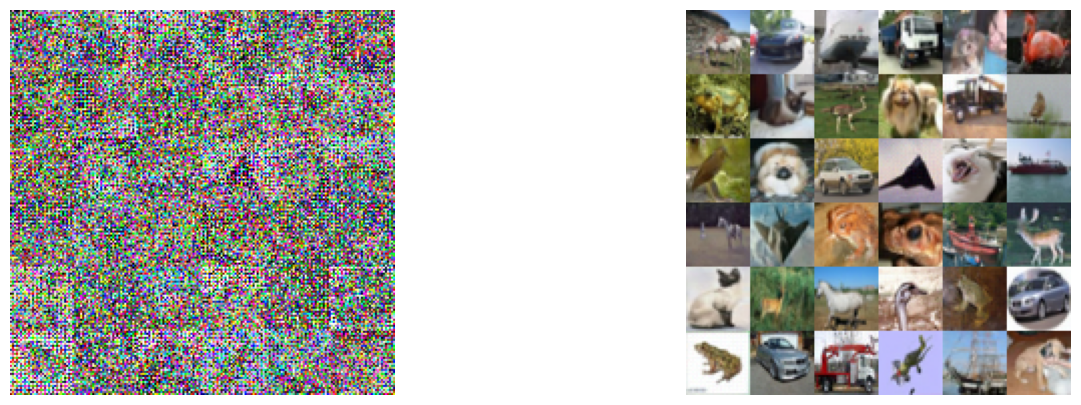

In [24]:
figsize(16,5)
plt.subplot(121)
plt.imshow(tutils.stack_imgs(inverse_scaler(x_0[:,:,:,:3]), 6, 6), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.subplot(122)
plt.imshow(tutils.stack_imgs(inverse_scaler(artifacts_0), 6, 6), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.box(False)
plt.savefig('jam/assets/superres_pictures.pdf', bbox_inches='tight')
plt.show()

In [25]:
metrics = np.load(f'jam/checkpoint/{ckpt_id}/eval/report.npz')
for k in metrics.keys():
    print(k, metrics[k])

IS 10.926171
fid 1.4370565
mean_bpd -1.0
std_bpd 0.0


In [92]:
import pandas as pd

df = pd.read_csv(f'jam/logs/slurm-{ckpt_id}.out', skiprows=4, header=None)[:500]
print(df.head())
print(df.tail())
def str2np(string):
  return np.array(list(map(lambda s: int(s), string[len(' num_steps: '):][1:-1].split())))
nfes = np.array(list(map(lambda s: str2np(s), df[5].tolist())))

       0                       1     2     3    4                          5
0  0/500   artifacts.shape: (100  32.0  32.0   3)   num_steps: [28 27 26 30]
1  1/500   artifacts.shape: (100  32.0  32.0   3)   num_steps: [29 30 27 25]
2  2/500   artifacts.shape: (100  32.0  32.0   3)   num_steps: [27 27 28 30]
3  3/500   artifacts.shape: (100  32.0  32.0   3)   num_steps: [31 30 31 28]
4  4/500   artifacts.shape: (100  32.0  32.0   3)   num_steps: [25 27 29 28]
           0                       1     2     3    4  \
495  495/500   artifacts.shape: (100  32.0  32.0   3)   
496  496/500   artifacts.shape: (100  32.0  32.0   3)   
497  497/500   artifacts.shape: (100  32.0  32.0   3)   
498  498/500   artifacts.shape: (100  32.0  32.0   3)   
499  499/500   artifacts.shape: (100  32.0  32.0   3)   

                             5  
495   num_steps: [25 27 21 26]  
496   num_steps: [32 29 26 30]  
497   num_steps: [28 26 26 27]  
498   num_steps: [30 28 26 24]  
499   num_steps: [27 30 26 29]

In [93]:
nfes.mean()*6

165.873